# Store Category wise Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle

In [2]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
data=pd.read_pickle('/notebooks/final_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,lag_21,lag_28,lag_30,lag_45,lag_60,lag_80,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend
6098000,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1501,0,2015-03-09,11506,...,0.0,0.0,2.0,0.0,2.0,0.0,0.646973,0.0,0.669434,-0.669434
6098001,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1501,1,2015-03-09,11506,...,0.0,0.0,0.0,0.0,0.0,1.0,0.318359,1.0,0.304932,0.695312


In [4]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:00<00:00, 78.20it/s]


In [5]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [6]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [7]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 97.1 MB/s eta 0:00:00


In [8]:
data.drop(['date'],axis=1,inplace=True)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse

In [24]:
!pwd

/notebooks/store_category/Normal_model


In [26]:
from tqdm import tqdm
import joblib
import gc
import warnings
warnings.filterwarnings('ignore')
valid_preds={}
eval_preds={}
validation = pd.DataFrame()
evaluation = pd.DataFrame()
category=d_cat_id.keys()
stores = d_store_id.keys()
for store in tqdm(stores):
    for cat in category:
        df = data[(data['store_id']==store) &(data['cat_id']==cat)]
        #Split the data
        X_train, y_train = df[df['d']<1914].drop('demand',axis=1), df[df['d']<1914]['demand']
        X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('demand',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['demand']
        X_test = df[df['d']>=1942].drop('demand',axis=1)

        #Train and validate
        model = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300
        )
        print('*****Prediction for Store: {}, and category: {}*****'.format(d_store_id[store],d_cat_id[cat]))
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                 eval_metric='rmse', verbose=20, early_stopping_rounds=20)
        y_pred_valid=model.predict(X_valid)
        y_pred_eval=model.predict(X_test)
        X_valid['demand']=y_pred_valid
        X_test['demand']=y_pred_eval
        X_valid=X_valid[['id','d','demand']]
        X_test=X_test[['id','d','demand']]
        validation=validation.append(X_valid)
        evaluation=evaluation.append(X_test)
        filename = 'model'+str(d_store_id[store])+str(d_cat_id[cat])+'.pkl'
        # save model
        joblib.dump(model, filename)
        del model, X_train, y_train, X_valid, y_valid
        gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

*****Prediction for Store: CA_1, and category: HOBBIES*****
[20]	training's rmse: 0.365895	training's l2: 0.133879	valid_1's rmse: 0.212881	valid_1's l2: 0.0453184
*****Prediction for Store: CA_1, and category: HOUSEHOLD*****
[20]	training's rmse: 0.159597	training's l2: 0.0254713	valid_1's rmse: 0.0697879	valid_1's l2: 0.00487035
[40]	training's rmse: 0.156347	training's l2: 0.0244445	valid_1's rmse: 0.0702501	valid_1's l2: 0.00493508
*****Prediction for Store: CA_1, and category: FOODS*****
[20]	training's rmse: 0.424934	training's l2: 0.180569	valid_1's rmse: 0.299285	valid_1's l2: 0.0895713
[40]	training's rmse: 0.406144	training's l2: 0.164953	valid_1's rmse: 0.30038	valid_1's l2: 0.0902279


 10%|█         | 1/10 [00:11<01:40, 11.22s/it]

*****Prediction for Store: CA_2, and category: HOBBIES*****
[20]	training's rmse: 0.332863	training's l2: 0.110798	valid_1's rmse: 0.217744	valid_1's l2: 0.0474123
[40]	training's rmse: 0.308159	training's l2: 0.0949619	valid_1's rmse: 0.19865	valid_1's l2: 0.0394619
[60]	training's rmse: 0.286895	training's l2: 0.0823089	valid_1's rmse: 0.184798	valid_1's l2: 0.0341501
[80]	training's rmse: 0.273575	training's l2: 0.0748434	valid_1's rmse: 0.176342	valid_1's l2: 0.0310966
[100]	training's rmse: 0.259293	training's l2: 0.067233	valid_1's rmse: 0.170716	valid_1's l2: 0.0291439
[120]	training's rmse: 0.247267	training's l2: 0.0611408	valid_1's rmse: 0.170676	valid_1's l2: 0.0291303
[140]	training's rmse: 0.239187	training's l2: 0.0572107	valid_1's rmse: 0.166719	valid_1's l2: 0.0277952
[160]	training's rmse: 0.230862	training's l2: 0.0532971	valid_1's rmse: 0.168668	valid_1's l2: 0.0284489
*****Prediction for Store: CA_2, and category: HOUSEHOLD*****
[20]	training's rmse: 0.173	training'

 20%|██        | 2/10 [00:25<01:44, 13.03s/it]

*****Prediction for Store: CA_3, and category: HOBBIES*****
[20]	training's rmse: 0.977247	training's l2: 0.955012	valid_1's rmse: 0.39289	valid_1's l2: 0.154362
*****Prediction for Store: CA_3, and category: HOUSEHOLD*****
[20]	training's rmse: 0.224351	training's l2: 0.0503336	valid_1's rmse: 0.0787761	valid_1's l2: 0.00620568
[40]	training's rmse: 0.216882	training's l2: 0.047038	valid_1's rmse: 0.0766277	valid_1's l2: 0.0058718
[60]	training's rmse: 0.210089	training's l2: 0.0441372	valid_1's rmse: 0.0747105	valid_1's l2: 0.00558165
*****Prediction for Store: CA_3, and category: FOODS*****
[20]	training's rmse: 0.804189	training's l2: 0.64672	valid_1's rmse: 0.572	valid_1's l2: 0.327184
[40]	training's rmse: 0.773677	training's l2: 0.598577	valid_1's rmse: 0.560543	valid_1's l2: 0.314209
[60]	training's rmse: 0.748378	training's l2: 0.56007	valid_1's rmse: 0.546358	valid_1's l2: 0.298507
[80]	training's rmse: 0.727535	training's l2: 0.529307	valid_1's rmse: 0.542184	valid_1's l2: 0

 30%|███       | 3/10 [00:36<01:26, 12.32s/it]

*****Prediction for Store: CA_4, and category: HOBBIES*****
[20]	training's rmse: 0.272818	training's l2: 0.0744299	valid_1's rmse: 0.299675	valid_1's l2: 0.0898049
[40]	training's rmse: 0.258557	training's l2: 0.0668519	valid_1's rmse: 0.28614	valid_1's l2: 0.0818763
[60]	training's rmse: 0.247804	training's l2: 0.0614066	valid_1's rmse: 0.271921	valid_1's l2: 0.0739413
[80]	training's rmse: 0.238969	training's l2: 0.0571062	valid_1's rmse: 0.264594	valid_1's l2: 0.0700101
[100]	training's rmse: 0.231572	training's l2: 0.0536256	valid_1's rmse: 0.255541	valid_1's l2: 0.065301
[120]	training's rmse: 0.224952	training's l2: 0.0506032	valid_1's rmse: 0.250606	valid_1's l2: 0.0628033
[140]	training's rmse: 0.219326	training's l2: 0.0481041	valid_1's rmse: 0.244459	valid_1's l2: 0.0597601
[160]	training's rmse: 0.213706	training's l2: 0.0456704	valid_1's rmse: 0.243416	valid_1's l2: 0.0592514
[180]	training's rmse: 0.207883	training's l2: 0.0432152	valid_1's rmse: 0.236614	valid_1's l2: 0.

 40%|████      | 4/10 [01:02<01:44, 17.42s/it]

*****Prediction for Store: TX_1, and category: HOBBIES*****
[20]	training's rmse: 0.338583	training's l2: 0.114638	valid_1's rmse: 0.279517	valid_1's l2: 0.0781296
[40]	training's rmse: 0.308217	training's l2: 0.0949976	valid_1's rmse: 0.259161	valid_1's l2: 0.0671646
[60]	training's rmse: 0.290457	training's l2: 0.0843652	valid_1's rmse: 0.245779	valid_1's l2: 0.0604071
[80]	training's rmse: 0.279435	training's l2: 0.0780837	valid_1's rmse: 0.241564	valid_1's l2: 0.0583533
[100]	training's rmse: 0.269481	training's l2: 0.0726199	valid_1's rmse: 0.236286	valid_1's l2: 0.0558312
[120]	training's rmse: 0.260703	training's l2: 0.0679659	valid_1's rmse: 0.230124	valid_1's l2: 0.0529572
[140]	training's rmse: 0.253672	training's l2: 0.0643497	valid_1's rmse: 0.225928	valid_1's l2: 0.0510437
[160]	training's rmse: 0.247374	training's l2: 0.0611941	valid_1's rmse: 0.222282	valid_1's l2: 0.0494093
[180]	training's rmse: 0.240952	training's l2: 0.0580576	valid_1's rmse: 0.219565	valid_1's l2: 0

 50%|█████     | 5/10 [01:17<01:23, 16.73s/it]

*****Prediction for Store: TX_2, and category: HOBBIES*****
[20]	training's rmse: 0.296034	training's l2: 0.0876362	valid_1's rmse: 0.275086	valid_1's l2: 0.0756725
[40]	training's rmse: 0.269848	training's l2: 0.0728181	valid_1's rmse: 0.270644	valid_1's l2: 0.0732483
[60]	training's rmse: 0.251056	training's l2: 0.0630289	valid_1's rmse: 0.269735	valid_1's l2: 0.0727571
[80]	training's rmse: 0.237999	training's l2: 0.0566436	valid_1's rmse: 0.264118	valid_1's l2: 0.0697584
[100]	training's rmse: 0.224874	training's l2: 0.0505682	valid_1's rmse: 0.258921	valid_1's l2: 0.0670401
[120]	training's rmse: 0.211052	training's l2: 0.0445431	valid_1's rmse: 0.246209	valid_1's l2: 0.0606187
[140]	training's rmse: 0.200265	training's l2: 0.0401063	valid_1's rmse: 0.23675	valid_1's l2: 0.0560505
[160]	training's rmse: 0.191959	training's l2: 0.0368482	valid_1's rmse: 0.229069	valid_1's l2: 0.0524725
[180]	training's rmse: 0.184066	training's l2: 0.0338803	valid_1's rmse: 0.220664	valid_1's l2: 0

 60%|██████    | 6/10 [01:37<01:10, 17.68s/it]

*****Prediction for Store: TX_3, and category: HOBBIES*****
[20]	training's rmse: 0.197412	training's l2: 0.0389714	valid_1's rmse: 0.172986	valid_1's l2: 0.029924
[40]	training's rmse: 0.187964	training's l2: 0.0353305	valid_1's rmse: 0.162566	valid_1's l2: 0.0264276
[60]	training's rmse: 0.182245	training's l2: 0.0332133	valid_1's rmse: 0.159426	valid_1's l2: 0.0254165
[80]	training's rmse: 0.176697	training's l2: 0.031222	valid_1's rmse: 0.156401	valid_1's l2: 0.0244613
[100]	training's rmse: 0.172313	training's l2: 0.0296919	valid_1's rmse: 0.154661	valid_1's l2: 0.0239199
[120]	training's rmse: 0.168154	training's l2: 0.0282758	valid_1's rmse: 0.152974	valid_1's l2: 0.023401
[140]	training's rmse: 0.165281	training's l2: 0.0273178	valid_1's rmse: 0.152824	valid_1's l2: 0.0233552
*****Prediction for Store: TX_3, and category: HOUSEHOLD*****
[20]	training's rmse: 0.201834	training's l2: 0.0407371	valid_1's rmse: 0.10506	valid_1's l2: 0.0110375
*****Prediction for Store: TX_3, and ca

 70%|███████   | 7/10 [01:48<00:46, 15.45s/it]

*****Prediction for Store: WI_1, and category: HOBBIES*****
[20]	training's rmse: 0.306087	training's l2: 0.0936892	valid_1's rmse: 0.171705	valid_1's l2: 0.0294827
[40]	training's rmse: 0.28993	training's l2: 0.0840595	valid_1's rmse: 0.159548	valid_1's l2: 0.0254555
[60]	training's rmse: 0.27834	training's l2: 0.0774732	valid_1's rmse: 0.150127	valid_1's l2: 0.0225382
[80]	training's rmse: 0.26829	training's l2: 0.0719793	valid_1's rmse: 0.142198	valid_1's l2: 0.0202203
[100]	training's rmse: 0.257893	training's l2: 0.0665089	valid_1's rmse: 0.140385	valid_1's l2: 0.0197081
[120]	training's rmse: 0.249752	training's l2: 0.0623762	valid_1's rmse: 0.133108	valid_1's l2: 0.0177177
[140]	training's rmse: 0.242574	training's l2: 0.0588422	valid_1's rmse: 0.129731	valid_1's l2: 0.0168301
*****Prediction for Store: WI_1, and category: HOUSEHOLD*****
[20]	training's rmse: 0.108959	training's l2: 0.0118721	valid_1's rmse: 0.0652621	valid_1's l2: 0.00425914
[40]	training's rmse: 0.105199	train

 80%|████████  | 8/10 [02:01<00:29, 14.93s/it]

*****Prediction for Store: WI_2, and category: HOBBIES*****
[20]	training's rmse: 0.238004	training's l2: 0.0566458	valid_1's rmse: 0.293958	valid_1's l2: 0.0864114
[40]	training's rmse: 0.217011	training's l2: 0.0470936	valid_1's rmse: 0.281343	valid_1's l2: 0.0791541
[60]	training's rmse: 0.206304	training's l2: 0.0425612	valid_1's rmse: 0.277375	valid_1's l2: 0.0769367
[80]	training's rmse: 0.198137	training's l2: 0.0392582	valid_1's rmse: 0.270354	valid_1's l2: 0.0730914
[100]	training's rmse: 0.191511	training's l2: 0.0366764	valid_1's rmse: 0.267737	valid_1's l2: 0.071683
[120]	training's rmse: 0.182528	training's l2: 0.0333165	valid_1's rmse: 0.253548	valid_1's l2: 0.0642864
[140]	training's rmse: 0.176618	training's l2: 0.0311939	valid_1's rmse: 0.246566	valid_1's l2: 0.0607948
[160]	training's rmse: 0.171636	training's l2: 0.0294591	valid_1's rmse: 0.241006	valid_1's l2: 0.0580841
[180]	training's rmse: 0.164195	training's l2: 0.0269602	valid_1's rmse: 0.231034	valid_1's l2: 0

 90%|█████████ | 9/10 [02:18<00:15, 15.57s/it]

*****Prediction for Store: WI_3, and category: HOBBIES*****
[20]	training's rmse: 0.268503	training's l2: 0.0720941	valid_1's rmse: 0.23394	valid_1's l2: 0.0547278
[40]	training's rmse: 0.240082	training's l2: 0.0576395	valid_1's rmse: 0.221729	valid_1's l2: 0.0491636
[60]	training's rmse: 0.225517	training's l2: 0.0508581	valid_1's rmse: 0.213381	valid_1's l2: 0.0455315
[80]	training's rmse: 0.214675	training's l2: 0.0460855	valid_1's rmse: 0.20376	valid_1's l2: 0.0415183
[100]	training's rmse: 0.205386	training's l2: 0.0421836	valid_1's rmse: 0.192672	valid_1's l2: 0.0371224
[120]	training's rmse: 0.198535	training's l2: 0.0394162	valid_1's rmse: 0.18624	valid_1's l2: 0.0346855
[140]	training's rmse: 0.192063	training's l2: 0.036888	valid_1's rmse: 0.179787	valid_1's l2: 0.0323234
[160]	training's rmse: 0.186264	training's l2: 0.0346944	valid_1's rmse: 0.177096	valid_1's l2: 0.031363
[180]	training's rmse: 0.181003	training's l2: 0.0327622	valid_1's rmse: 0.170568	valid_1's l2: 0.029

100%|██████████| 10/10 [02:42<00:00, 16.23s/it]


In [27]:
actual = True
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = data[(data['d']>=1914) & (data['d']<=1941)][['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
else:
    #Get the actual validation results
    validation = validation[['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
validation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.995642,0.001356,0.001356,0.001356,0.000243,0.994996,1.007315,0.000243,5.998203,...,1.997364,2.993472,1.001695,0.001356,0.001356,0.001536,0.997479,0.001536,0.000243,0.000243
1,FOODS_1_001_CA_2_validation,0.000346,2.987366,0.001144,-0.001505,-0.002243,1.011025,3.990930,-0.000404,0.001359,...,1.007848,0.001441,0.001441,0.997930,0.996784,0.000303,0.000303,0.996397,2.003403,0.001441
2,FOODS_1_001_CA_3_validation,0.998788,-0.002147,1.011132,0.000077,8.008539,1.000962,-0.000977,0.000420,1.001349,...,0.999175,2.005963,1.993555,0.002663,0.002663,0.999112,0.002663,2.990106,1.996783,1.996783
3,FOODS_1_001_CA_4_validation,-0.000979,1.004066,0.000224,0.000224,-0.000979,-0.000149,0.997092,0.000516,-0.000213,...,1.003075,-0.000213,-0.000213,-0.000213,-0.000213,1.003075,0.995668,-0.000149,0.000364,0.000364
4,FOODS_1_001_TX_1_validation,0.004194,0.004194,0.996168,0.005818,0.997792,0.005818,1.004708,0.995597,1.005913,...,0.995021,0.997301,0.997301,0.995021,4.964705,0.007541,1.987927,1.991902,0.007541,1.991902


In [28]:
evaluation=evaluation[['id','d','demand']]
evaluation['id']=evaluation['id'].map(d_id)
evaluation = pd.pivot(evaluation, index='id', columns='d', values='demand').reset_index()
evaluation.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.000243,0.000243,0.000243,0.000243,-0.000532,-0.000532,-0.000532,-0.000532,-0.000532,...,-0.000532,-0.000532,-0.000532,-0.000532,-0.000532,-0.000532,-0.000532,-0.000532,-0.000532,-0.000532
1,FOODS_1_001_CA_2_evaluation,0.000303,0.000303,0.000303,0.000303,-0.000108,0.001722,0.001334,-0.000108,-0.000108,...,-0.000861,-0.002511,-0.002511,-0.000861,-0.000861,-0.000861,-0.000861,-0.000861,-0.002511,-0.002511
2,FOODS_1_001_CA_3_evaluation,0.001984,0.001984,0.001984,0.001984,0.001473,0.000723,0.001913,0.001913,0.001913,...,-0.001366,-0.001366,-0.001366,-0.001366,-0.001366,-0.001366,-0.001366,-0.001366,-0.001366,-0.001366
3,FOODS_1_001_CA_4_evaluation,0.000364,0.000364,-0.000213,-0.000213,-0.000213,-0.000213,-0.000213,-0.000213,-0.000213,...,-0.000309,-0.000309,-0.000309,-0.000309,-0.000309,-0.000309,-0.000309,-0.000309,-0.000309,-0.000309
4,FOODS_1_001_TX_1_evaluation,0.007541,0.007714,0.005473,0.007606,0.007200,0.004959,0.007200,0.005237,0.005237,...,0.004194,0.004194,0.004194,0.004194,0.004194,0.004194,0.004194,0.004194,0.004194,0.004194


In [29]:
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('store_category_lgbm_submission.csv',index=False)

In [30]:
!pwd

/notebooks/store_category/Normal_model


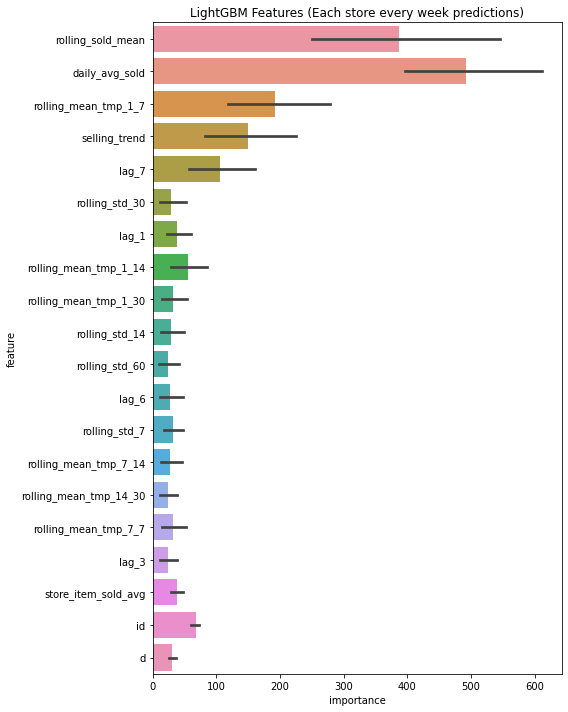

In [32]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'demand']
for filename in os.listdir('/notebooks/store_category/Normal_model'):
    if 'model' in filename:
        # load model
        filename=os.path.join('/notebooks/store_category/Normal_model', filename)
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (Each store every week predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

# Weekly Model

In [3]:
data=pd.read_pickle('/notebooks/final_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,lag_21,lag_28,lag_30,lag_45,lag_60,lag_80,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend
6098000,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1501,0,2015-03-09,11506,...,0.0,0.0,2.0,0.0,2.0,0.0,0.646973,0.0,0.669434,-0.669434
6098001,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1501,1,2015-03-09,11506,...,0.0,0.0,0.0,0.0,0.0,1.0,0.318359,1.0,0.304932,0.695312


In [4]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:00<00:00, 73.61it/s]


In [5]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [6]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [7]:
data.drop(['date'],axis=1,inplace=True)

In [14]:
!pwd

/notebooks/store_category/weekly_model


In [9]:
os.chdir('../.')

In [13]:
os.chdir('/notebooks/store_category/weekly_model')

In [18]:
from tqdm import tqdm
import joblib
import gc
import warnings
warnings.filterwarnings('ignore')
valid_preds={}
eval_preds={}
validation = pd.DataFrame()
evaluation = pd.DataFrame()
category=d_cat_id.keys()
stores = d_store_id.keys()
for store in tqdm(stores):
    for cat in category:
        df = data[(data['store_id']==store) &(data['cat_id']==cat)]
        #Split the data
        count=0
        for week in range(0,28,7):
            count+=1
            print('********Prediction for Store:{}, Category:{} and week_{}*************'.format(d_store_id[store],d_cat_id[cat],count))
            X_train, y_train = df[df['d']<1914+week].drop('demand',axis=1), df[df['d']<1914+week]['demand']
            X_valid, y_valid = df[(df['d']>=1914+week) & (df['d']<=1920+week)].drop('demand',axis=1), df[(df['d']>=1914+week) & (df['d']<=1920+week)]['demand']
            X_test = df[(df['d']>=1942+week) & (df['d']<=1948+week)].drop('demand',axis=1)

            #Train and validate
            model = LGBMRegressor(objective ='tweedie',
              tweedie_variance_power=1.5,
              n_estimators=1000,
              learning_rate=0.3,
              subsample=0.8,
              colsample_bytree=0.8,
              max_depth=8,
              num_leaves=50,
              min_child_weight=300
            )
            model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                  eval_metric='rmse', verbose=20, early_stopping_rounds=20)
            y_pred_valid=model.predict(X_valid)
            y_pred_eval=model.predict(X_test)
            X_valid['demand']=y_pred_valid
            X_test['demand']=y_pred_eval
            X_valid=X_valid[['id','d','demand']]
            X_test=X_test[['id','d','demand']]
            validation = validation.append(X_valid)
            evaluation = evaluation.append(X_test)
            del X_train, y_train, y_valid
            filename = 'model_'+str(d_store_id[store])+'_'+str(d_cat_id[cat])+'week_'+str(count)+'.pkl'
            # save model
            joblib.dump(model, filename)
            del model,  X_valid
            gc.collect()    

  0%|          | 0/10 [00:00<?, ?it/s]

********Prediction for Store:CA_1, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.129823	training's tweedie: 2.04926	valid_1's rmse: 0.0282648	valid_1's tweedie: 2.05432
[40]	training's rmse: 0.113713	training's tweedie: 2.04625	valid_1's rmse: 0.0275687	valid_1's tweedie: 2.0513
********Prediction for Store:CA_1, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.128031	training's tweedie: 2.04934	valid_1's rmse: 0.0357121	valid_1's tweedie: 2.15209
[40]	training's rmse: 0.110602	training's tweedie: 2.04628	valid_1's rmse: 0.0359872	valid_1's tweedie: 2.1491
********Prediction for Store:CA_1, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.126865	training's tweedie: 2.05102	valid_1's rmse: 0.0427032	valid_1's tweedie: 2.2736
[40]	training's rmse: 0.114445	training's tweedie: 2.04803	valid_1's rmse: 0.036491	valid_1's tweedie: 2.27074
[60]	training's rmse: 0.101504	training's tweedie: 2.04735	valid_1's rmse: 0.0320044	valid_1's tweedie: 

 10%|█         | 1/10 [10:42<1:36:21, 642.44s/it]

[80]	training's rmse: 0.109199	training's tweedie: 3.60284	valid_1's rmse: 0.0269738	valid_1's tweedie: 4.05029
********Prediction for Store:CA_2, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.0885784	training's tweedie: 1.63237	valid_1's rmse: 0.0325788	valid_1's tweedie: 1.87519
[40]	training's rmse: 0.0752038	training's tweedie: 1.62948	valid_1's rmse: 0.0426455	valid_1's tweedie: 1.87241
********Prediction for Store:CA_2, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.0876019	training's tweedie: 1.63643	valid_1's rmse: 0.0264113	valid_1's tweedie: 1.87363
[40]	training's rmse: 0.0749129	training's tweedie: 1.63357	valid_1's rmse: 0.0222572	valid_1's tweedie: 1.87081
[60]	training's rmse: 0.0660083	training's tweedie: 1.63304	valid_1's rmse: 0.0217707	valid_1's tweedie: 1.87033
********Prediction for Store:CA_2, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.0861632	training's tweedie: 1.64032	valid_1's rmse: 0.0330441	valid_1's

 20%|██        | 2/10 [19:55<1:18:36, 589.58s/it]

********Prediction for Store:CA_3, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.300407	training's tweedie: 2.24986	valid_1's rmse: 0.03674	valid_1's tweedie: 2.40183
[40]	training's rmse: 0.215309	training's tweedie: 2.24677	valid_1's rmse: 0.0317947	valid_1's tweedie: 2.39883
********Prediction for Store:CA_3, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.295391	training's tweedie: 2.25238	valid_1's rmse: 0.0381971	valid_1's tweedie: 2.35055
[40]	training's rmse: 0.212445	training's tweedie: 2.24937	valid_1's rmse: 0.0372579	valid_1's tweedie: 2.3476
********Prediction for Store:CA_3, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.288402	training's tweedie: 2.25398	valid_1's rmse: 0.0275293	valid_1's tweedie: 2.24625
[40]	training's rmse: 0.216695	training's tweedie: 2.25114	valid_1's rmse: 0.0320949	valid_1's tweedie: 2.24347
********Prediction for Store:CA_3, Category:HOBBIES and week_4*************
[20]	training's rmse: 0.291

 30%|███       | 3/10 [36:14<1:29:32, 767.55s/it]

********Prediction for Store:CA_4, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.112895	training's tweedie: 1.51433	valid_1's rmse: 0.0249569	valid_1's tweedie: 1.56723
[40]	training's rmse: 0.103228	training's tweedie: 1.51165	valid_1's rmse: 0.0257998	valid_1's tweedie: 1.56456
********Prediction for Store:CA_4, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.112221	training's tweedie: 1.51521	valid_1's rmse: 0.025578	valid_1's tweedie: 1.61877
[40]	training's rmse: 0.0979831	training's tweedie: 1.51253	valid_1's rmse: 0.0251121	valid_1's tweedie: 1.61615
********Prediction for Store:CA_4, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.111316	training's tweedie: 1.51691	valid_1's rmse: 0.0556615	valid_1's tweedie: 1.6382
********Prediction for Store:CA_4, Category:HOBBIES and week_4*************
[20]	training's rmse: 0.10994	training's tweedie: 1.51886	valid_1's rmse: 0.309299	valid_1's tweedie: 1.6381
[40]	training's rmse: 0.0981

 40%|████      | 4/10 [48:56<1:16:31, 765.31s/it]

********Prediction for Store:TX_1, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.138297	training's tweedie: 1.27073	valid_1's rmse: 0.0598628	valid_1's tweedie: 1.37998
********Prediction for Store:TX_1, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.138053	training's tweedie: 1.27256	valid_1's rmse: 0.0155054	valid_1's tweedie: 1.28297
[40]	training's rmse: 0.11453	training's tweedie: 1.27001	valid_1's rmse: 0.0215348	valid_1's tweedie: 1.28049
********Prediction for Store:TX_1, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.138525	training's tweedie: 1.27272	valid_1's rmse: 0.0662916	valid_1's tweedie: 1.34757
********Prediction for Store:TX_1, Category:HOBBIES and week_4*************
[20]	training's rmse: 0.135577	training's tweedie: 1.27393	valid_1's rmse: 0.035486	valid_1's tweedie: 1.49569
********Prediction for Store:TX_1, Category:HOUSEHOLD and week_1*************
[20]	training's rmse: 0.0639069	training's tweedie: 2.03032	

 50%|█████     | 5/10 [57:23<56:01, 672.20s/it]  

********Prediction for Store:TX_2, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.0839223	training's tweedie: 1.65947	valid_1's rmse: 0.166608	valid_1's tweedie: 1.82038
[40]	training's rmse: 0.0691121	training's tweedie: 1.65673	valid_1's rmse: 0.161455	valid_1's tweedie: 1.81771
[60]	training's rmse: 0.0618299	training's tweedie: 1.65619	valid_1's rmse: 0.162342	valid_1's tweedie: 1.81719
********Prediction for Store:TX_2, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.0819035	training's tweedie: 1.66214	valid_1's rmse: 0.0248196	valid_1's tweedie: 1.88122
[40]	training's rmse: 0.0664722	training's tweedie: 1.65939	valid_1's rmse: 0.0299056	valid_1's tweedie: 1.87857
********Prediction for Store:TX_2, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.0777815	training's tweedie: 1.66574	valid_1's rmse: 0.0485256	valid_1's tweedie: 1.86549
[40]	training's rmse: 0.0630395	training's tweedie: 1.66294	valid_1's rmse: 0.0436304	valid_1's t

 60%|██████    | 6/10 [1:13:52<51:59, 779.85s/it]

********Prediction for Store:TX_3, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.0740917	training's tweedie: 1.57553	valid_1's rmse: 0.0281589	valid_1's tweedie: 1.79443
[40]	training's rmse: 0.0695263	training's tweedie: 1.57271	valid_1's rmse: 0.0220677	valid_1's tweedie: 1.79168
[60]	training's rmse: 0.0653715	training's tweedie: 1.57225	valid_1's rmse: 0.0205165	valid_1's tweedie: 1.79124
[80]	training's rmse: 0.0621662	training's tweedie: 1.57204	valid_1's rmse: 0.0201604	valid_1's tweedie: 1.79106
[100]	training's rmse: 0.0586345	training's tweedie: 1.57191	valid_1's rmse: 0.0202317	valid_1's tweedie: 1.79094
[120]	training's rmse: 0.054843	training's tweedie: 1.5718	valid_1's rmse: 0.0179401	valid_1's tweedie: 1.79083
[140]	training's rmse: 0.0521795	training's tweedie: 1.57172	valid_1's rmse: 0.0181772	valid_1's tweedie: 1.79076
[160]	training's rmse: 0.048734	training's tweedie: 1.57166	valid_1's rmse: 0.0181606	valid_1's tweedie: 1.79071
********Prediction 

 70%|███████   | 7/10 [1:29:45<41:49, 836.49s/it]

********Prediction for Store:WI_1, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.111321	training's tweedie: 1.71286	valid_1's rmse: 0.0289119	valid_1's tweedie: 1.89725
[40]	training's rmse: 0.0946393	training's tweedie: 1.70992	valid_1's rmse: 0.031411	valid_1's tweedie: 1.89443
********Prediction for Store:WI_1, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.113267	training's tweedie: 1.71594	valid_1's rmse: 0.0304791	valid_1's tweedie: 1.85248
[40]	training's rmse: 0.0957188	training's tweedie: 1.713	valid_1's rmse: 0.0329721	valid_1's tweedie: 1.84965
********Prediction for Store:WI_1, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.108938	training's tweedie: 1.71817	valid_1's rmse: 0.0193156	valid_1's tweedie: 1.82286
[40]	training's rmse: 0.0904923	training's tweedie: 1.71534	valid_1's rmse: 0.0537045	valid_1's tweedie: 1.82007
********Prediction for Store:WI_1, Category:HOBBIES and week_4*************
[20]	training's rmse: 0.

 80%|████████  | 8/10 [1:40:13<25:40, 770.27s/it]

********Prediction for Store:WI_2, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.110868	training's tweedie: 1.16993	valid_1's rmse: 0.0618571	valid_1's tweedie: 1.39701
[40]	training's rmse: 0.0976698	training's tweedie: 1.16632	valid_1's rmse: 0.0607713	valid_1's tweedie: 1.39349
********Prediction for Store:WI_2, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.108153	training's tweedie: 1.17372	valid_1's rmse: 0.0384981	valid_1's tweedie: 1.33264
********Prediction for Store:WI_2, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.109567	training's tweedie: 1.17507	valid_1's rmse: 0.0451571	valid_1's tweedie: 1.41933
********Prediction for Store:WI_2, Category:HOBBIES and week_4*************
[20]	training's rmse: 0.108964	training's tweedie: 1.17902	valid_1's rmse: 0.111015	valid_1's tweedie: 1.41916
[40]	training's rmse: 0.0934261	training's tweedie: 1.17649	valid_1's rmse: 0.105096	valid_1's tweedie: 1.41672
[60]	training's rmse: 0.

 90%|█████████ | 9/10 [1:51:45<12:25, 745.59s/it]

********Prediction for Store:WI_3, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.0889682	training's tweedie: 1.18446	valid_1's rmse: 0.0185997	valid_1's tweedie: 1.36384
[40]	training's rmse: 0.0756055	training's tweedie: 1.18185	valid_1's rmse: 0.0158015	valid_1's tweedie: 1.36132
[60]	training's rmse: 0.0677663	training's tweedie: 1.18148	valid_1's rmse: 0.0153232	valid_1's tweedie: 1.36098
********Prediction for Store:WI_3, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.0879074	training's tweedie: 1.18745	valid_1's rmse: 0.0601491	valid_1's tweedie: 1.41673
[40]	training's rmse: 0.074206	training's tweedie: 1.18485	valid_1's rmse: 0.060924	valid_1's tweedie: 1.41422
********Prediction for Store:WI_3, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.08862	training's tweedie: 1.19122	valid_1's rmse: 0.0369338	valid_1's tweedie: 1.28977
[40]	training's rmse: 0.0746481	training's tweedie: 1.18858	valid_1's rmse: 0.0412635	valid_1's tw

100%|██████████| 10/10 [2:01:40<00:00, 730.09s/it]


In [19]:
actual = True
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = data[(data['d']>=1914) & (data['d']<=1941)][['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
else:
    #Get the actual validation results
    validation = validation[['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
validation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.974391e+00,1.127961e-07,1.118095e-07,6.350792e-08,1.043300e-07,1.019971e+00,1.007910,1.534598e-06,5.970864e+00,...,1.990287,3.002593e+00,9.972195e-01,2.796519e-07,2.690174e-07,2.624882e-07,1.004914e+00,2.728669e-07,2.712597e-07,3.236058e-07
1,FOODS_1_001_CA_2_validation,1.865900e-06,2.992081e+00,1.950354e-06,1.928315e-06,1.928315e-06,9.964899e-01,3.961047,3.529597e-04,3.546481e-04,...,1.000357,5.626115e-08,5.125482e-08,9.999883e-01,9.971717e-01,8.032389e-07,5.061185e-07,1.009314e+00,2.010430e+00,9.202784e-07
2,FOODS_1_001_CA_3_validation,1.001325e+00,1.825927e-04,1.005956e+00,1.841964e-04,7.935278e+00,1.011628e+00,0.000334,2.017440e-06,1.011900e+00,...,1.010054,2.025803e+00,1.986303e+00,1.046118e-06,1.044905e-06,1.004416e+00,1.008528e-06,2.989656e+00,2.002234e+00,2.001741e+00
3,FOODS_1_001_CA_4_validation,3.468279e-08,9.976628e-01,3.673239e-08,3.673239e-08,3.479663e-08,2.969366e-08,1.001862,5.598965e-08,1.033685e-07,...,0.983181,1.238715e-07,8.815088e-08,2.163540e-06,2.153083e-06,9.967147e-01,9.958817e-01,2.217479e-06,1.427846e-06,1.427846e-06
4,FOODS_1_001_TX_1_validation,4.530219e-05,4.290600e-05,9.583298e-01,4.994424e-05,9.968434e-01,5.022150e-05,1.001532,9.969755e-01,9.977806e-01,...,1.005064,1.027610e+00,9.869526e-01,1.003667e+00,5.005135e+00,1.195112e-06,1.993977e+00,1.993073e+00,1.197098e-06,1.993977e+00


In [20]:
evaluation=evaluation[['id','d','demand']]
evaluation['id']=evaluation['id'].map(d_id)
evaluation = pd.pivot(evaluation, index='id', columns='d', values='demand').reset_index()
evaluation.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,1.126284e-07,1.126284e-07,1.126284e-07,1.126556e-07,1.118409e-07,1.123626e-07,1.103353e-07,1.394093e-06,1.394093e-06,...,4.023481e-07,4.023481e-07,4.023481e-07,1.846213e-07,1.846213e-07,1.846213e-07,1.835394e-07,1.835394e-07,1.835394e-07,2.023616e-07
1,FOODS_1_001_CA_2_evaluation,1.905449e-06,1.713355e-06,1.078550e-06,1.078550e-06,1.650891e-06,1.450262e-06,1.411272e-06,1.950668e-04,1.950668e-04,...,4.190050e-08,3.775944e-08,3.775944e-08,8.947227e-07,8.947227e-07,8.947227e-07,8.947227e-07,8.947227e-07,8.947227e-07,8.960240e-07
2,FOODS_1_001_CA_3_evaluation,3.284046e-04,3.284046e-04,3.284046e-04,3.284046e-04,3.218472e-04,2.703080e-04,1.825927e-04,1.641090e-06,1.641090e-06,...,2.066332e-06,2.066332e-06,1.981943e-06,8.146302e-07,8.146302e-07,8.471638e-07,8.471638e-07,8.471638e-07,8.146302e-07,8.069981e-07
3,FOODS_1_001_CA_4_evaluation,1.877186e-08,1.799349e-08,3.178321e-08,2.381731e-08,2.320526e-08,2.329943e-08,2.329943e-08,6.856482e-08,6.806475e-08,...,8.569571e-08,8.569571e-08,8.569571e-08,1.949373e-06,1.949373e-06,1.949373e-06,1.949373e-06,1.949373e-06,1.949373e-06,1.949373e-06
4,FOODS_1_001_TX_1_evaluation,9.162357e-05,8.820434e-05,8.584945e-05,9.008247e-05,7.634982e-05,5.022150e-05,5.138568e-05,1.476351e-08,1.476351e-08,...,3.301996e-06,3.369839e-06,3.206892e-06,5.918801e-07,5.527778e-07,5.527778e-07,5.527778e-07,5.527778e-07,5.527778e-07,5.527778e-07


In [21]:
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('store_category_weekly_lgbm_submission.csv',index=False)

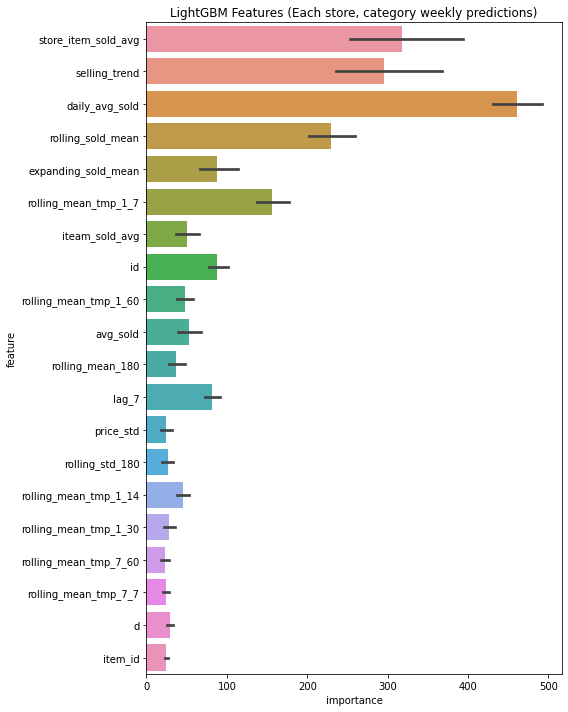

In [22]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'demand']
for filename in os.listdir('/notebooks/store_category/weekly_model'):
    if 'model' in filename:
        # load model
        filename=os.path.join('/notebooks/store_category/weekly_model', filename)
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (Each store, category weekly predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

# Reccursive Model

In [10]:
data=pd.read_pickle('/notebooks/final_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,lag_21,lag_28,lag_30,lag_45,lag_60,lag_80,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend
6098000,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1501,0,2015-03-09,11506,...,0.0,0.0,2.0,0.0,2.0,0.0,0.646973,0.0,0.669434,-0.669434
6098001,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1501,1,2015-03-09,11506,...,0.0,0.0,0.0,0.0,0.0,1.0,0.318359,1.0,0.304932,0.695312


In [11]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:00<00:00, 171.62it/s]


In [12]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [13]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [14]:
data.drop(['date'],axis=1,inplace=True)

In [15]:
os.chdir('/notebooks/store_category/Reccursive_model')

In [16]:
!pwd

/notebooks/store_category/Reccursive_model


In [17]:
!pip install lightgbm

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse

In [19]:
def get_recursion(data):
    lags = [1,2,3,4,5,6,7]
    for lag in lags:
        data["lag_" + str(lag)] = data.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] ,as_index=False)["demand"].shift(lag).astype(np.float16)
    return data

In [20]:
from tqdm import tqdm
import joblib
import gc
import warnings
warnings.filterwarnings('ignore')
valid_preds={}
eval_preds={}
validation = pd.DataFrame()
evaluation = pd.DataFrame()
category=d_cat_id.keys()
stores = d_store_id.keys()
for store in tqdm(stores):
    for cat in category:
        df = data[(data['store_id']==store) &(data['cat_id']==cat)]
        #Split the data
        count=0
        model = LGBMRegressor(objective ='tweedie',
              tweedie_variance_power=1.5,
              n_estimators=1000,
              learning_rate=0.3,
              subsample=0.8,
              colsample_bytree=0.8,
              max_depth=8,
              num_leaves=50,
              min_child_weight=300
            )
        for week in range(0,28,7):
            count+=1
            print('********Prediction for Store:{}, Category:{} and week_{}*************'.format(d_store_id[store],d_cat_id[cat],count))
            df = get_recursion(df)
            X_train, y_train = df[df['d']<1914+week].drop('demand',axis=1), df[df['d']<1914+week]['demand']
            X_valid, y_valid = df[(df['d']>=1914+week) & (df['d']<=1920+week)].drop('demand',axis=1), df[(df['d']>=1914+week) & (df['d']<=1920+week)]['demand']
            X_test = df[(df['d']>=1942+week) & (df['d']<=1948+week)].drop('demand',axis=1)

            #Train and validate
            model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                  eval_metric='rmse', verbose=20, early_stopping_rounds=20)
            y_pred_valid=model.predict(X_valid)
            y_pred_eval=model.predict(X_test)
            X_valid['demand']=y_pred_valid
            X_test['demand']=y_pred_eval
            X_valid=X_valid[['id','d','demand']]
            X_test = X_test[['id','d','demand']]
            validation=validation.append(X_valid)
            evaluation=evaluation.append(X_test)
            del X_train, y_train, y_valid
            data=pd.merge(data, X_valid, on=['id','d'], how='left')
            index = data.index[data['demand_y'].apply(np.isnan)]
            data.loc[index, 'demand_y']=data.loc[index, 'demand_x']
            data.drop('demand_x', axis=1,inplace=True)
            data.rename({'demand_y':'demand'},axis=1, inplace=True)
        filename = 'model_'+str(d_store_id[store])+'_'+str(d_cat_id[cat])+'week_'+str(count)+'.pkl'
        # save model
        joblib.dump(model, filename)
        del model,  X_valid
        gc.collect()     

  0%|          | 0/10 [00:00<?, ?it/s]

********Prediction for Store:CA_1, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.129277	training's tweedie: 2.04926	valid_1's rmse: 0.0295609	valid_1's tweedie: 2.05431
[40]	training's rmse: 0.113528	training's tweedie: 2.04621	valid_1's rmse: 0.0282802	valid_1's tweedie: 2.05126
[60]	training's rmse: 0.102561	training's tweedie: 2.04561	valid_1's rmse: 0.0269601	valid_1's tweedie: 2.05065
********Prediction for Store:CA_1, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.128013	training's tweedie: 2.04934	valid_1's rmse: 0.0384836	valid_1's tweedie: 2.1521
[40]	training's rmse: 0.1094	training's tweedie: 2.04634	valid_1's rmse: 0.038236	valid_1's tweedie: 2.14917
[60]	training's rmse: 0.0961287	training's tweedie: 2.04574	valid_1's rmse: 0.0322194	valid_1's tweedie: 2.14857
[80]	training's rmse: 0.0900719	training's tweedie: 2.04548	valid_1's rmse: 0.0303374	valid_1's tweedie: 2.14832
[100]	training's rmse: 0.084896	training's tweedie: 2.04532	valid_

 10%|█         | 1/10 [05:07<46:10, 307.86s/it]

********Prediction for Store:CA_2, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.088777	training's tweedie: 1.63238	valid_1's rmse: 0.0320546	valid_1's tweedie: 1.87519
[40]	training's rmse: 0.0736018	training's tweedie: 1.62948	valid_1's rmse: 0.0453866	valid_1's tweedie: 1.8724
********Prediction for Store:CA_2, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.0888765	training's tweedie: 1.63644	valid_1's rmse: 0.0261586	valid_1's tweedie: 1.87363
[40]	training's rmse: 0.0755466	training's tweedie: 1.63356	valid_1's rmse: 0.0215765	valid_1's tweedie: 1.8708
[60]	training's rmse: 0.0671246	training's tweedie: 1.63307	valid_1's rmse: 0.0213038	valid_1's tweedie: 1.87034
[80]	training's rmse: 0.0616549	training's tweedie: 1.63288	valid_1's rmse: 0.0200227	valid_1's tweedie: 1.87017
[100]	training's rmse: 0.0579942	training's tweedie: 1.63276	valid_1's rmse: 0.0192847	valid_1's tweedie: 1.87006
********Prediction for Store:CA_2, Category:HOBBIES and wee

 20%|██        | 2/10 [16:12<1:09:00, 517.57s/it]

********Prediction for Store:CA_3, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.2978	training's tweedie: 2.24985	valid_1's rmse: 0.0333212	valid_1's tweedie: 2.40181
[40]	training's rmse: 0.218122	training's tweedie: 2.24673	valid_1's rmse: 0.0313807	valid_1's tweedie: 2.39879
********Prediction for Store:CA_3, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.293999	training's tweedie: 2.25238	valid_1's rmse: 0.0366666	valid_1's tweedie: 2.35054
[40]	training's rmse: 0.225119	training's tweedie: 2.24936	valid_1's rmse: 0.0374726	valid_1's tweedie: 2.34757
********Prediction for Store:CA_3, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.287463	training's tweedie: 2.25399	valid_1's rmse: 0.0273926	valid_1's tweedie: 2.24625
[40]	training's rmse: 0.21409	training's tweedie: 2.25086	valid_1's rmse: 0.0459299	valid_1's tweedie: 2.24318
********Prediction for Store:CA_3, Category:HOBBIES and week_4*************
[20]	training's rmse: 0.291

 30%|███       | 3/10 [33:21<1:27:39, 751.30s/it]

********Prediction for Store:CA_4, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.111588	training's tweedie: 1.51433	valid_1's rmse: 0.0245021	valid_1's tweedie: 1.56723
[40]	training's rmse: 0.0984897	training's tweedie: 1.51161	valid_1's rmse: 0.0241544	valid_1's tweedie: 1.56455
[60]	training's rmse: 0.0912492	training's tweedie: 1.51115	valid_1's rmse: 0.023838	valid_1's tweedie: 1.5641
********Prediction for Store:CA_4, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.11128	training's tweedie: 1.51521	valid_1's rmse: 0.0265398	valid_1's tweedie: 1.61877
[40]	training's rmse: 0.100024	training's tweedie: 1.51251	valid_1's rmse: 0.0263364	valid_1's tweedie: 1.61613
********Prediction for Store:CA_4, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.111253	training's tweedie: 1.51691	valid_1's rmse: 0.0528365	valid_1's tweedie: 1.6382
********Prediction for Store:CA_4, Category:HOBBIES and week_4*************
[20]	training's rmse: 0.11

 40%|████      | 4/10 [47:12<1:18:16, 782.80s/it]

********Prediction for Store:TX_1, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.139515	training's tweedie: 1.27074	valid_1's rmse: 0.0554128	valid_1's tweedie: 1.37998
********Prediction for Store:TX_1, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.137765	training's tweedie: 1.27256	valid_1's rmse: 0.0145211	valid_1's tweedie: 1.28297
[40]	training's rmse: 0.114013	training's tweedie: 1.26996	valid_1's rmse: 0.0212067	valid_1's tweedie: 1.28046
********Prediction for Store:TX_1, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.138401	training's tweedie: 1.27273	valid_1's rmse: 0.066113	valid_1's tweedie: 1.34758
********Prediction for Store:TX_1, Category:HOBBIES and week_4*************
[20]	training's rmse: 0.137647	training's tweedie: 1.27394	valid_1's rmse: 0.0311885	valid_1's tweedie: 1.49568
[40]	training's rmse: 0.115112	training's tweedie: 1.27137	valid_1's rmse: 0.0352388	valid_1's tweedie: 1.49325
********Prediction for St

 50%|█████     | 5/10 [52:18<50:53, 610.65s/it]  

********Prediction for Store:TX_2, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.0826642	training's tweedie: 1.65948	valid_1's rmse: 0.172449	valid_1's tweedie: 1.82038
[40]	training's rmse: 0.0697678	training's tweedie: 1.65674	valid_1's rmse: 0.166613	valid_1's tweedie: 1.81771
********Prediction for Store:TX_2, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.0842086	training's tweedie: 1.66215	valid_1's rmse: 0.0256483	valid_1's tweedie: 1.88122
[40]	training's rmse: 0.0721192	training's tweedie: 1.65936	valid_1's rmse: 0.0261387	valid_1's tweedie: 1.87857
********Prediction for Store:TX_2, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.0797831	training's tweedie: 1.66575	valid_1's rmse: 0.0517737	valid_1's tweedie: 1.86549
[40]	training's rmse: 0.0659337	training's tweedie: 1.66294	valid_1's rmse: 0.0499739	valid_1's tweedie: 1.86276
[60]	training's rmse: 0.0582812	training's tweedie: 1.66247	valid_1's rmse: 0.04212	valid_1's tw

 60%|██████    | 6/10 [1:05:46<45:11, 677.91s/it]

********Prediction for Store:TX_3, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.0742735	training's tweedie: 1.57553	valid_1's rmse: 0.0273456	valid_1's tweedie: 1.79442
[40]	training's rmse: 0.0694492	training's tweedie: 1.57271	valid_1's rmse: 0.0228555	valid_1's tweedie: 1.79167
[60]	training's rmse: 0.0652211	training's tweedie: 1.57224	valid_1's rmse: 0.0221285	valid_1's tweedie: 1.79124
********Prediction for Store:TX_3, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.0734096	training's tweedie: 1.57919	valid_1's rmse: 0.0325975	valid_1's tweedie: 1.79312
********Prediction for Store:TX_3, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.0727452	training's tweedie: 1.5827	valid_1's rmse: 0.0304078	valid_1's tweedie: 1.69772
[40]	training's rmse: 0.0684492	training's tweedie: 1.58	valid_1's rmse: 0.0262754	valid_1's tweedie: 1.69501
********Prediction for Store:TX_3, Category:HOBBIES and week_4*************
[20]	training's rmse: 

 70%|███████   | 7/10 [1:21:04<37:49, 756.52s/it]

********Prediction for Store:WI_1, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.111186	training's tweedie: 1.71287	valid_1's rmse: 0.0358001	valid_1's tweedie: 1.89725
[40]	training's rmse: 0.0958741	training's tweedie: 1.70995	valid_1's rmse: 0.0387996	valid_1's tweedie: 1.89453
********Prediction for Store:WI_1, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.113017	training's tweedie: 1.71595	valid_1's rmse: 0.0296074	valid_1's tweedie: 1.85249
[40]	training's rmse: 0.0966894	training's tweedie: 1.713	valid_1's rmse: 0.0345431	valid_1's tweedie: 1.84967
********Prediction for Store:WI_1, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.108856	training's tweedie: 1.71818	valid_1's rmse: 0.0193745	valid_1's tweedie: 1.82286
[40]	training's rmse: 0.092	training's tweedie: 1.71533	valid_1's rmse: 0.0562427	valid_1's tweedie: 1.82006
********Prediction for Store:WI_1, Category:HOBBIES and week_4*************
[20]	training's rmse: 0.107

 80%|████████  | 8/10 [1:37:04<27:22, 821.15s/it]

********Prediction for Store:WI_2, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.110842	training's tweedie: 1.16994	valid_1's rmse: 0.0623156	valid_1's tweedie: 1.39701
[40]	training's rmse: 0.0977707	training's tweedie: 1.16633	valid_1's rmse: 0.0679648	valid_1's tweedie: 1.3935
********Prediction for Store:WI_2, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.108363	training's tweedie: 1.17247	valid_1's rmse: 0.0374939	valid_1's tweedie: 1.3314
********Prediction for Store:WI_2, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.109368	training's tweedie: 1.17508	valid_1's rmse: 0.0454892	valid_1's tweedie: 1.41934
********Prediction for Store:WI_2, Category:HOBBIES and week_4*************
[20]	training's rmse: 0.109029	training's tweedie: 1.17903	valid_1's rmse: 0.111555	valid_1's tweedie: 1.41916
[40]	training's rmse: 0.0932186	training's tweedie: 1.17646	valid_1's rmse: 0.104001	valid_1's tweedie: 1.41668
[60]	training's rmse: 0.08

 90%|█████████ | 9/10 [1:52:12<14:08, 848.16s/it]

********Prediction for Store:WI_3, Category:HOBBIES and week_1*************
[20]	training's rmse: 0.0889712	training's tweedie: 1.18447	valid_1's rmse: 0.018933	valid_1's tweedie: 1.36384
[40]	training's rmse: 0.0760923	training's tweedie: 1.18187	valid_1's rmse: 0.0166457	valid_1's tweedie: 1.36135
[60]	training's rmse: 0.0664613	training's tweedie: 1.18147	valid_1's rmse: 0.0145918	valid_1's tweedie: 1.36097
********Prediction for Store:WI_3, Category:HOBBIES and week_2*************
[20]	training's rmse: 0.0884659	training's tweedie: 1.18746	valid_1's rmse: 0.0560611	valid_1's tweedie: 1.41673
[40]	training's rmse: 0.074074	training's tweedie: 1.18487	valid_1's rmse: 0.0539848	valid_1's tweedie: 1.41426
[60]	training's rmse: 0.0668215	training's tweedie: 1.18446	valid_1's rmse: 0.0527334	valid_1's tweedie: 1.41388
********Prediction for Store:WI_3, Category:HOBBIES and week_3*************
[20]	training's rmse: 0.0883033	training's tweedie: 1.19123	valid_1's rmse: 0.0376468	valid_1's 

100%|██████████| 10/10 [2:05:11<00:00, 751.18s/it]


In [21]:
actual = True
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = data[(data['d']>=1914) & (data['d']<=1941)][['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
else:
    #Get the actual validation results
    validation = validation[['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
validation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,2.009200e+00,8.024524e-08,7.826122e-08,4.452954e-08,7.342545e-08,1.008386e+00,1.001087,1.774008e-07,6.001150e+00,...,1.994127,3.000041e+00,1.000784e+00,1.921078e-07,1.875861e-07,1.236099e-07,1.001460e+00,1.923267e-07,1.759411e-07,2.338040e-07
1,FOODS_1_001_CA_2_validation,1.668916e-06,2.986384e+00,1.744351e-06,1.724644e-06,1.724644e-06,9.974280e-01,3.962868,1.937103e-04,1.946398e-04,...,0.999368,9.165525e-07,9.165525e-07,1.000570e+00,9.979142e-01,9.942657e-07,6.266019e-07,1.010375e+00,2.014171e+00,1.140257e-06
2,FOODS_1_001_CA_3_validation,1.010618e+00,1.841327e-04,1.015292e+00,1.841327e-04,7.959827e+00,1.015191e+00,0.000336,9.829885e-06,9.935855e-01,...,1.001202,2.006891e+00,1.986317e+00,1.300954e-06,1.300954e-06,1.003833e+00,1.255090e-06,2.980570e+00,1.998679e+00,1.998679e+00
3,FOODS_1_001_CA_4_validation,2.534035e-07,9.881406e-01,2.609224e-07,2.609224e-07,2.466540e-07,2.227233e-07,0.994424,3.495286e-07,6.619952e-07,...,1.000006,1.247045e-07,8.895191e-08,7.329234e-07,7.294069e-07,9.799857e-01,9.784551e-01,8.295604e-07,5.329589e-07,5.329589e-07
4,FOODS_1_001_TX_1_validation,4.530019e-05,4.290383e-05,9.615842e-01,4.995189e-05,9.972939e-01,5.022803e-05,1.001962,9.984432e-01,9.973942e-01,...,1.006400,1.014131e+00,1.001759e+00,1.002231e+00,5.001557e+00,9.947074e-08,2.002608e+00,2.001021e+00,9.958562e-08,2.001021e+00


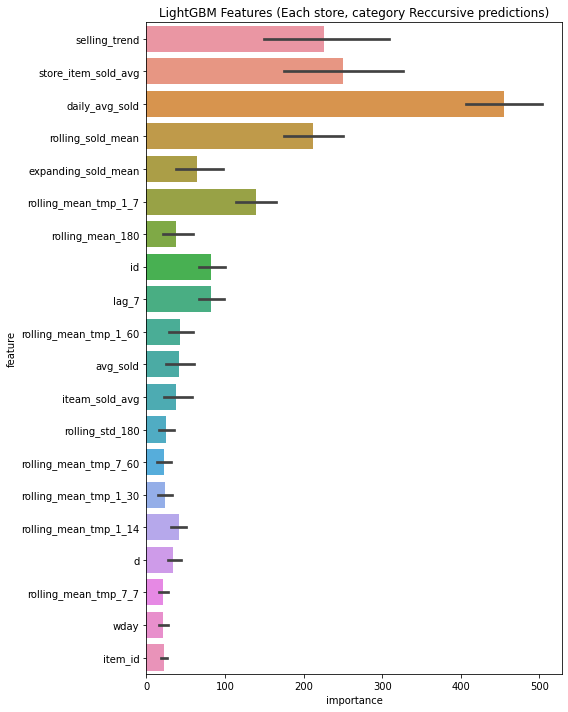

In [25]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'demand']
for filename in os.listdir('/notebooks/store_category/Reccursive_model'):
    if 'model' in filename:
        # load model
        filename=os.path.join('/notebooks/store_category/Reccursive_model', filename)
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (Each store, category Reccursive predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

In [26]:
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('store_category_reccursive_lgbm_submission.csv',index=False)